In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata # For the interpolation

In [16]:
def load_data(path):
    """
    Loads the data from a text file. 
    Columns 1, 2, 3 should be the x, y, z coordinates respectively.
    The separator should be a space.
    Slip direction should be aligned in the x direction.
    The normal direction should be aligned in the z direction.

    Input:
    path: The path to the text file.

    Output:
    data: The data from the text file.
    """

    data = np.loadtxt(path, usecols=(0,1,2)) # Only x, y, z coordinates

    # Shift the data so that the minimum x and y values are 0
    data[:,0] -= np.min(data[:,0])
    data[:,1] -= np.min(data[:,1])

    return data

def grid_data(data):

    x_max, x_min = np.max(data[:,0]), np.min(data[:,0])
    y_max, y_min = np.max(data[:,1]), np.min(data[:,1])

    x_length = abs(round(x_max - x_min, 3))
    y_length = abs(round(y_max - y_min, 3))

    x_spacing = 0.1
    y_spacing = 0.1

    # Create the grid
    x_grid = np.linspace(np.min(data[:,0]), np.max(data[:,0]), int(x_length//x_spacing))
    y_grid = np.linspace(np.min(data[:,1]), np.max(data[:,1]), int(y_length//y_spacing))
    X, Y = np.meshgrid(x_grid, y_grid)

    # Interpolate the data
    z_grid = griddata((data[:,0], data[:,1]), data[:,2], (X, Y), method='linear')

    
    return X, Y, z_grid

def plot_topography(x, y, z):
    """
    Plots the topography of the surface.

    Input:
    data: The data from the text file.
    """
    # Initialize two side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # plot with continous colour map
    ax1.contourf(x, y, z, 100, cmap=plt.cm.jet)
    fig.colorbar(ax1.contourf(x, y, z, 100, cmap=plt.cm.jet), ax=ax1)
    ax1.set_title('Topography')
    ax1.set_xlabel('x (mm)')
    ax1.set_ylabel('y (mm)')
    ax1.set_aspect('equal')
    
    # plot only top five percent of z values

    # Get the top 5% of z values
    z_max = np.nanmax(z)
    z_min = np.nanmin(z)
    z_range = z_max - z_min
    z_top = z_min + 0.8*z_range

    # Plot the top 5% of z values
    ax2.contourf(x, y, z, 100, cmap=plt.cm.jet, vmin=z_top, vmax=z_max)
    fig.colorbar(ax2.contourf(x, y, z, 100, cmap=plt.cm.jet, vmin=z_top, vmax=z_max), ax=ax2)
    ax2.set_title('Top 5% of Topography')
    ax2.set_xlabel('x (mm)')
    # ax2.set_ylabel('y (m)')
    ax2.set_aspect('equal')

    # plot points on top of the topography
    # point1 = [ 1.82962799, 64.44378662]  # avly02
    # point2 = [113.98273468, 59.42633057]
    # point3 = [ 27.73814011, 121.67933083]

    point1 = [69.51483727, 41.54374695] # avly05
    point2 = [ 49.02947617, 105.43762207]
    point3 = [89.53873372, 21.51835632]

    # point1 = [48.53989601, 99.67406845] # avly04
    # point2 = [28.53955841,  1.90855408]
    # point3 = [73.29051274, 79.63948441]

    ax1.scatter(point1[0], point1[1], color='black', marker='X', s=100)
    ax1.scatter(point2[0], point2[1], color='black', marker='X', s=100)
    ax1.scatter(point3[0], point3[1], color='black', marker='X', s=100)

def plot_raw_topography(x, y, z):
    # plots the topography with the same colour map, only the whole range of z values is used

    # initialize single plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))

    # plot with continous colour map
    ax.contourf(x, y, z, 100, cmap=plt.cm.jet)
    fig.colorbar(ax.contourf(x, y, z, 100, cmap=plt.cm.jet), ax=ax)
    ax.set_title('Topography')
    ax.set_xlabel('x (mm)')
    ax.set_ylabel('y (mm)')
    ax.set_aspect('equal')

    

def rotation_axis(data):
    """
    Finds the three points the surface would rest upon if it were lying on a flat surface.
    
    """

    def distance(index1, index2):
        """
        Calculates the distance between two points.
        """
        return np.sqrt((data[index1,0] - data[index2,0])**2 + (data[index1,1] - data[index2,1])**2)

    x = data[:,0]
    y = data[:,1]
    z = data[:,2]        

    # Range of z values
    z_range = np.max(z) - np.min(z)

    # List of z values, each 2% of the range
    z_list = np.arange(np.min(z), np.max(z), z_range/50)
    z_list = z_list[::-1]

    # Find top point
    top_point = np.max(z)
    top_point_index = np.where(z == top_point)[0][0]   

    second_top_point_index = None
    # Iterating through the z values
    for z_portion in z_list:
        candidate_indices = np.where(z > z_portion)

        # sort candidate indices by descending z value
        candidate_indices = np.array(sorted(candidate_indices[0], key=lambda x: z[x], reverse=True))

        # Find the top point which is not within 20 milimetres of the top point
        for index in candidate_indices:
            if (abs(x[index] - x[top_point_index]) > 20) and (abs(y[index] - y[top_point_index]) > 20):
                second_top_point_index = index
                break
    
    # find the third point which is not within 5 milimetres of the top point or the second top point

    third_top_point_index = None
    # Iterating through the z values
    for z_portion in z_list:
        candidate_indices = np.where(z > z_portion)

        # sort candidate indices by descending z value
        candidate_indices = np.array(sorted(candidate_indices[0], key=lambda x: z[x], reverse=True))

        # list of potential third point indices
        possible_third_points = []

        # Find the top point which is not within 20 milimetres of the top point
        i = 0
        for index in candidate_indices:
            if (abs(x[index] - x[top_point_index]) > 10) and (abs(y[index] - y[top_point_index]) > 10) and (abs(x[index] - x[second_top_point_index]) > 10) and (abs(y[index] - y[second_top_point_index]) > 10):
                possible_third_points.append(index)
                i += 1

                if i == 5:
                    break

        # Find most prominent third point
        if len(possible_third_points) > 0:
            # calculate the distance from each point to the closest point with a higher z value
            distances = np.zeros(len(possible_third_points))
            for i in range(len(possible_third_points)):
                distances[i] = distance(possible_third_points[i], top_point_index)

            # find the index of the point with the largest distance
            third_top_point_index = possible_third_points[np.argmax(distances)]

    print(data[top_point_index], data[second_top_point_index], data[third_top_point_index])
        
    return np.array([x[second_top_point_index] - x[top_point_index], y[second_top_point_index] - y[top_point_index], z[second_top_point_index] - z[top_point_index]])

def find_flat(data):
    """
    
    """

    # Find the isolation of each point
    # isolation is the distance from one point to the nearest point with a higher z value
    x = data[:,0]
    y = data[:,1]
    z = data[:,2]

    # Find the isolation of each point
    isolation = np.zeros(len(x))
    for i in range(len(x)):
        # Find the distance to each other point
        distances = np.sqrt((x[i] - x)**2 + (y[i] - y)**2 + (z[i] - z)**2)

        # Find the distance to the nearest point with a higher z value
        isolation[i] = np.min(distances[np.where(z > z[i])])

    # Plot the isolation of each point
    plt.figure()
    plt.scatter(x, y, c=isolation, cmap=plt.cm.jet)
    plt.colorbar()
    plt.title('Isolation of each point')
    plt.show()


        

In [18]:
# avly02 = load_data('../surfaces/AVLY02/AVLY02_full.txt')
# avly05 = load_data('../surfaces/AVLY05/AVLY05_full.txt')
# avly04 = load_data('../surfaces/AVLY04/AVLY04_full.txt')
countertop = load_data('../surfaces/new_flat/countertop_text.txt')

x, y, z = grid_data(countertop)

In [19]:
rotation_axis(avly04)

[48.53989601 99.67406845 14.55960751] [28.53955841  1.90855408 13.17917633] [68.05042601 86.05034256 13.14758682]


array([-20.0003376 , -97.76551437,  -1.38043118])

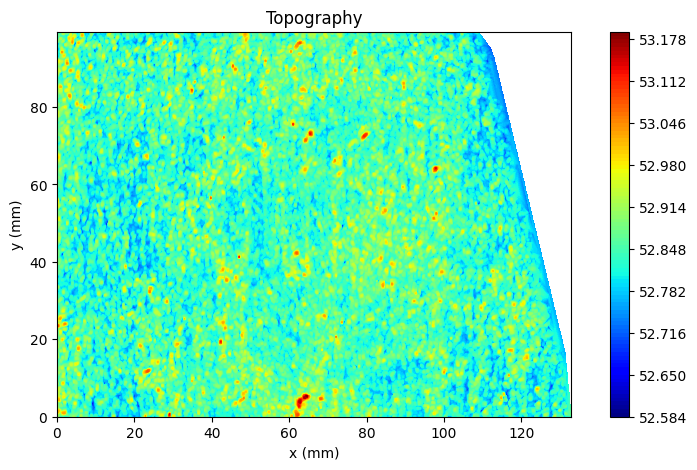

In [19]:
plot_raw_topography(x, y, z)
# find_flat(avly02)